# First iteration of tree-based models.

The hyperparameter optization process will be the following:
1. Train with default hyperaparameters.
2. Identify bias and variance.
3. Choose first range for hyperparameters based on results.
4. Train n models using HalvingRandomSearchCV from scikit learn.
5. Pick the regions of the hyperparameter space that yield the best results.
6. Centre the hyperparameter search on those regions and iterate.

The scoring will consist in:
1. Numerical scores for the testing subset: recall, precision, roc_auc, f1.
2. Numerical scores for the whole data: recall, precision, roc_auc, f1.
2. Visualization of the ROC curve for the whole data.
4. Confusion matrix for the whole data.

In this way we can see if each model over/underfits, comparing the test and total scores. Also, the ROC curve and the confusion matrix will show how each model is performing in the whole dataset.


In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
# For random number generation
from scipy.stats import randint, uniform

from sklearn.experimental import enable_halving_search_cv # Allow importing the experimental HalvingGridSearchCV

# Metrics and auxiliar libraries from sklearn.
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV, RepeatedStratifiedKFold, HalvingGridSearchCV

# Some auxiliary functions for scoring.
import scoring_utils

#DEV
import importlib as imp


In [4]:
# Import the dataframe cleaned and encoded during the feature importance process.
df_encoded = pd.read_csv('../data/df_encoded_interest.csv')

In [5]:
target = 'Default'
features_encoded = [feature for feature in df_encoded.columns if feature not in target]
# Our target and features are the same that we employed during the importance analysis.
print(f"Target: {target}")
print(f"Features: {features_encoded}")

Target: Default
Features: ['NAICS', 'Term', 'NewExist', 'FranchiseCode', 'RevLineCr', 'LowDoc', 'GrAppv', 'SBA_Appv', 'isNewBusiness', 'isFranchise', 'SBARatio', 'InterestRate', 'NAICS_i_0', 'NAICS_i_11', 'NAICS_i_21', 'NAICS_i_22', 'NAICS_i_23', 'NAICS_i_31', 'NAICS_i_32', 'NAICS_i_33', 'NAICS_i_42', 'NAICS_i_44', 'NAICS_i_45', 'NAICS_i_48', 'NAICS_i_49', 'NAICS_i_51', 'NAICS_i_52', 'NAICS_i_53', 'NAICS_i_54', 'NAICS_i_55', 'NAICS_i_56', 'NAICS_i_61', 'NAICS_i_62', 'NAICS_i_71', 'NAICS_i_72', 'NAICS_i_81', 'NAICS_i_92', 'UrbanRural_0', 'UrbanRural_1', 'UrbanRural_2']


In [6]:
# This split will be used in every model, so that they are scored against the same subset.
X_train, X_test, y_train, y_test = train_test_split(df_encoded[features_encoded], df_encoded[target], train_size = .9)
# Complete datasets
X_total = df_encoded[features_encoded]
y_total = df_encoded[target]

### Single Decision Tree Classifier

In [7]:
# Default check to identify bias/variance
from sklearn.tree import DecisionTreeClassifier

default_tree = DecisionTreeClassifier()
default_tree.fit(X_train, y_train)

yhat_train = default_tree.predict(X_train)
yhat_test = default_tree.predict(X_test)

default_tree_score = pd.concat((
    scoring_utils.get_metrics(y_train, yhat_train, "Default Tree Train"),
    scoring_utils.get_metrics(y_test, yhat_test, "Default Tree Test")
    ))

default_tree_score

,Recall,Precision,ROC,F1
Default Tree Train,0.996619,0.999985,0.998308,0.998299
Default Tree Test,0.771765,0.771198,0.862112,0.771481


In [8]:
default_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

It does overfit! Let's decrease the variance by tuning the hyperparameters.

In [9]:

# Grid of parameters for a single tree
param_grid = [
    {
        "min_samples_split": randint(100, 200),
        "max_depth": randint(14, 18)
    }
]

# Cross validation in 3 folds for our grid search parameter selection.
# It must be consistent across the folds, so the random state has to be fixed.
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=9)

single_tree_search = HalvingRandomSearchCV(
    estimator=DecisionTreeClassifier(class_weight='balanced'),
    param_distributions=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    n_candidates=1000
)

single_tree_search.fit(X_train, y_train)


/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/s

HalvingRandomSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=9),
                      estimator=DecisionTreeClassifier(class_weight='balanced'),
                      n_candidates=1000, n_jobs=-1,
                      param_distributions=[{'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17dc18290>,
                                            'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17cda3810>}],
                      scoring='recall')

In [10]:
scoring_utils.get_best_kernels(single_tree_search.cv_results_)

,params,mean_test_score,mean_fit_time
kernel,,,
14_125,"{'max_depth': 14, 'min_samples_split': 125}",0.896615,0.098773
16_127,"{'max_depth': 16, 'min_samples_split': 127}",0.895648,0.102100
16_127,"{'max_depth': 16, 'min_samples_split': 127}",0.872182,0.024641
14_125,"{'max_depth': 14, 'min_samples_split': 125}",0.871257,0.026028
16_120,"{'max_depth': 16, 'min_samples_split': 120}",0.871024,0.027612
...,...,...,...
17_192,"{'max_depth': 17, 'min_samples_split': 192}",0.444444,0.000994
17_136,"{'max_depth': 17, 'min_samples_split': 136}",0.444444,0.001040
15_177,"{'max_depth': 15, 'min_samples_split': 177}",0.444444,0.003322


In [11]:
# Let's use the best estimator to obtain test and overall scores 
single_tree_model = single_tree_search.best_estimator_

yhat_test = single_tree_model.predict(X_test)
yhat_total = single_tree_model.predict(X_total)

In [12]:
single_tree_test_score = scoring_utils.get_metrics(y_test, yhat_test, "Single Tree Test")
single_tree_total_score = scoring_utils.get_metrics(y_total, yhat_total, "Single Tree Total")

single_tree_score = pd.concat((single_tree_test_score, single_tree_total_score))
single_tree_score

,Recall,Precision,ROC,F1
Single Tree Test,0.924166,0.699398,0.920847,0.796224
Single Tree Total,0.935381,0.700798,0.926368,0.801273


In [13]:
print(f"We obtained a profit of ${scoring_utils.get_profit(X_total, y_total, yhat_total):,.2f}")

We obtained a profit of $6,617,997,262.15


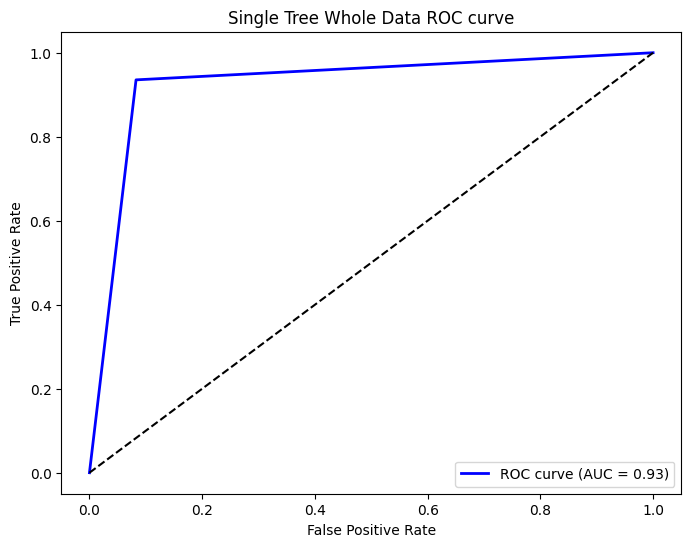

In [14]:
scoring_utils.get_roc_plot(y_total, yhat_total, "Single Tree Whole Data")

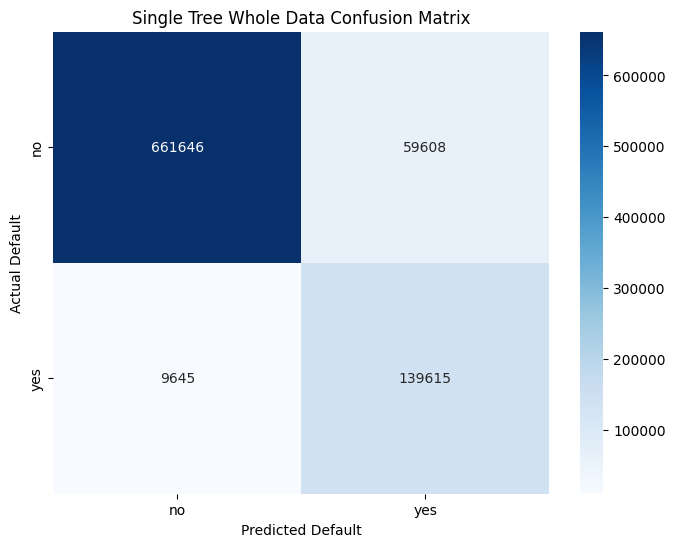

In [15]:
scoring_utils.get_confusion_matrix(y_total, yhat_total, "Single Tree Whole Data")

### Bagging classifier

In [16]:
# Default check to identify bias/variance
from sklearn.ensemble import BaggingClassifier

default_bagging = BaggingClassifier(DecisionTreeClassifier(), n_jobs=-1)
default_bagging.fit(X_train, y_train)

yhat_train = default_bagging.predict(X_train)
yhat_test = default_bagging.predict(X_test)

default_bagging_score = pd.concat((
    scoring_utils.get_metrics(y_train, yhat_train, "Default Bagging Train"),
    scoring_utils.get_metrics(y_test, yhat_test, "Default Bagging Test")
    ))

default_bagging_score

,Recall,Precision,ROC,F1
Default Bagging Train,0.973104,0.992504,0.985792,0.982708
Default Bagging Test,0.798290,0.844680,0.883906,0.820830


In [17]:
default_bagging.get_params()

{'base_estimator': 'deprecated',
 'bootstrap': True,
 'bootstrap_features': False,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeClassifier(),
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [18]:

# Grid of parameters for a bagging model
param_grid = [
    {
        "max_samples": [.8, .9, 1.0]
    }
]

# Cross validation in 3 folds for our grid search parameter selection.
# It must be consistent across the folds, so the random state has to be fixed.
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=9)

bagging_search = HalvingGridSearchCV(
    estimator=BaggingClassifier(n_estimators=10, estimator=single_tree_model),
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

bagging_search.fit(X_train, y_train)


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 261154
max_resources_: 783462
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 261154
Fitting 9 folds for each of 3 candidates, totalling 27 fits
----------
iter: 1
n_candidates: 1
n_resources: 783462
Fitting 9 folds for each of 1 candidates, totalling 9 fits


HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=9),
                    estimator=BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                 max_depth=14,
                                                                                 min_samples_split=125)),
                    n_jobs=-1, param_grid=[{'max_samples': [0.8, 0.9, 1.0]}],
                    scoring='recall', verbose=1)

In [19]:
scoring_utils.get_best_kernels(bagging_search.cv_results_)

,params,mean_test_score,mean_fit_time
kernel,,,
0.8,{'max_samples': 0.8},0.924012,39.956401
0.8,{'max_samples': 0.8},0.919474,10.966807
0.9,{'max_samples': 0.9},0.919130,10.682443
1.0,{'max_samples': 1.0},0.918695,9.512504


In [20]:
bagging_model = bagging_search.best_estimator_

yhat_test = bagging_model.predict(X_test)
yhat_total = bagging_model.predict(X_total)

In [21]:
bagging_test_score = scoring_utils.get_metrics(y_test, yhat_test, "Bagging Test")
bagging_total_score = scoring_utils.get_metrics(y_total, yhat_total, "Bagging Total")

bagging_score = pd.concat((bagging_test_score, bagging_total_score, single_tree_score))
bagging_score

,Recall,Precision,ROC,F1
Bagging Test,0.923632,0.710746,0.922793,0.803324
Bagging Total,0.931944,0.710712,0.926721,0.806430
Single Tree Test,0.924166,0.699398,0.920847,0.796224
Single Tree Total,0.935381,0.700798,0.926368,0.801273


In [22]:
print(f"We obtained a profit of ${scoring_utils.get_profit(X_total, y_total, yhat_total):,.2f}")

We obtained a profit of $6,630,318,713.10


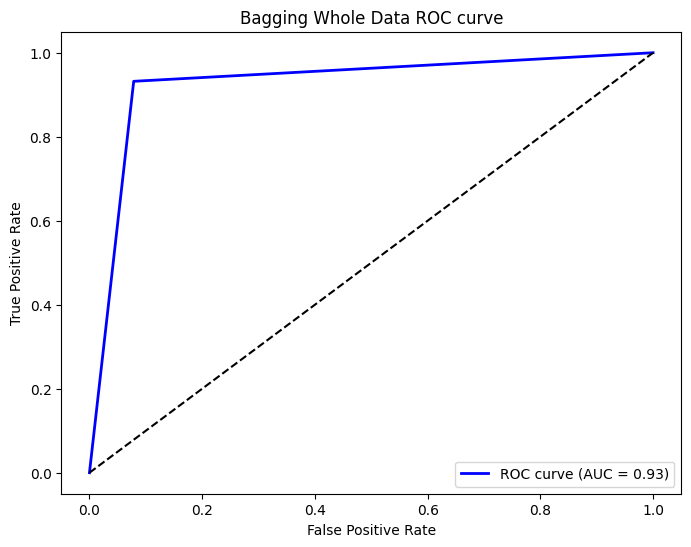

In [23]:
scoring_utils.get_roc_plot(y_total, yhat_total, "Bagging Whole Data")

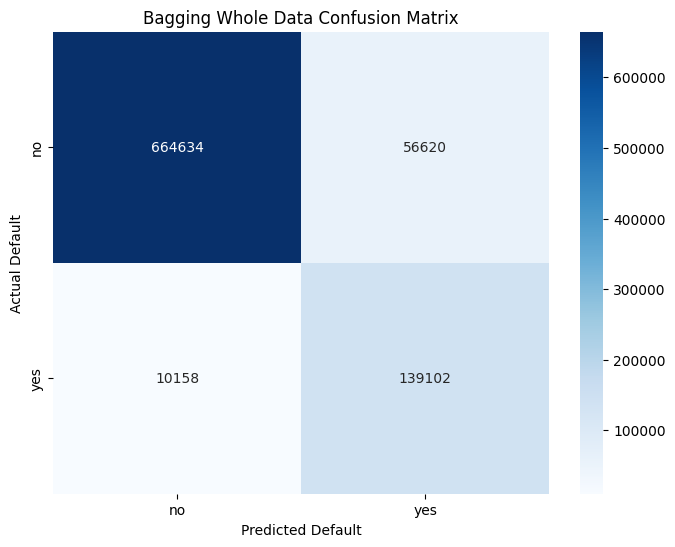

In [24]:
scoring_utils.get_confusion_matrix(y_total, yhat_total, "Bagging Whole Data")

### Random forest

In [25]:
# Default to check bias/variance
from sklearn.ensemble import RandomForestClassifier

default_forest = RandomForestClassifier(n_jobs=-1).fit(X_train, y_train)

yhat_train = default_forest.predict(X_train)
yhat_test = default_forest.predict(X_test)

default_forest_score = pd.concat((
    scoring_utils.get_metrics(y_train, yhat_train, 'Default Forest Train'),
    scoring_utils.get_metrics(y_test, yhat_test, 'Default Forest Test')
))

default_forest_score


,Recall,Precision,ROC,F1
Default Forest Train,0.997170,0.999343,0.998517,0.998256
Default Forest Test,0.755796,0.858400,0.864955,0.803837


In [26]:
default_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [27]:
# {'max_depth': 14, 'min_samples_split': 109} # One of my best trees!!!!!

param_grid = {
    'max_depth': [50, 100, 150], # This has a smaller effect, but 100 seems to work out fine.
    'min_samples_split': [10, 100, 1000] # This should be around 100
}

# Cross validation in 3 folds for our grid search parameter selection.
# It must be consistent across the folds, so the random state has to be fixed.
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=9)

random_forest_search = HalvingGridSearchCV(
    estimator=RandomForestClassifier(n_estimators=50, max_features=1.0, class_weight='balanced'),
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

random_forest_search.fit(X_train, y_train)


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 87051
max_resources_: 783462
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 87051
Fitting 9 folds for each of 9 candidates, totalling 81 fits
----------
iter: 1
n_candidates: 3
n_resources: 261153
Fitting 9 folds for each of 3 candidates, totalling 27 fits
----------
iter: 2
n_candidates: 1
n_resources: 783459
Fitting 9 folds for each of 1 candidates, totalling 9 fits


HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=9),
                    estimator=RandomForestClassifier(class_weight='balanced',
                                                     max_features=1.0,
                                                     n_estimators=50),
                    n_jobs=-1,
                    param_grid={'max_depth': [10, 100, None],
                                'min_samples_split': [10, 100, 1000]},
                    scoring='recall', verbose=1)

In [28]:
scoring_utils.get_best_kernels(random_forest_search.cv_results_)

,params,mean_test_score,mean_fit_time
kernel,,,
10_100,"{'max_depth': 10, 'min_samples_split': 100}",0.918355,153.463851
10_100,"{'max_depth': 10, 'min_samples_split': 100}",0.916768,35.340776
10_100,"{'max_depth': 10, 'min_samples_split': 100}",0.910790,10.929360
None_1000,"{'max_depth': None, 'min_samples_split': 1000}",0.909027,10.135567
10_1000,"{'max_depth': 10, 'min_samples_split': 1000}",0.908814,10.208742
100_100,"{'max_depth': 100, 'min_samples_split': 100}",0.908621,14.263642
None_100,"{'max_depth': None, 'min_samples_split': 100}",0.908376,14.801565
100_1000,"{'max_depth': 100, 'min_samples_split': 1000}",0.907581,10.815395
10_1000,"{'max_depth': 10, 'min_samples_split': 1000}",0.905919,37.239537


In [29]:
random_forest = random_forest_search.best_estimator_

yhat_test = random_forest.predict(X_test)
yhat_total = random_forest.predict(X_total)

In [30]:
forest_test_score = scoring_utils.get_metrics(y_test, yhat_test, "Random Forest Test")
forest_total_score = scoring_utils.get_metrics(y_total, yhat_total, "Random Forest Total")

forest_score = pd.concat((forest_test_score, forest_total_score, bagging_score))
forest_score

,Recall,Precision,ROC,F1
Random Forest Test,0.917953,0.674969,0.913086,0.777929
Random Forest Total,0.922565,0.670932,0.914462,0.776880
Bagging Test,0.923632,0.710746,0.922793,0.803324
Bagging Total,0.931944,0.710712,0.926721,0.806430
Single Tree Test,0.924166,0.699398,0.920847,0.796224
Single Tree Total,0.935381,0.700798,0.926368,0.801273


In [31]:
print(f"We obtained a profit of ${scoring_utils.get_profit(X_total, y_total, yhat_total):,.2f}")

We obtained a profit of $6,497,526,264.55


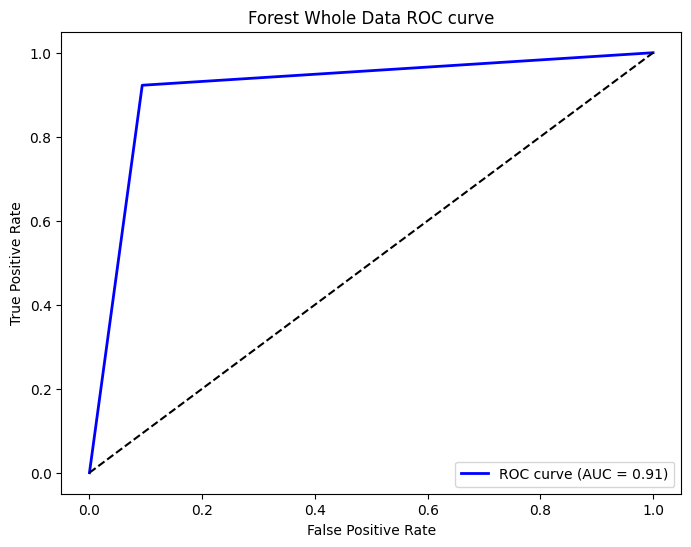

In [32]:
scoring_utils.get_roc_plot(y_total, yhat_total, "Forest Whole Data")

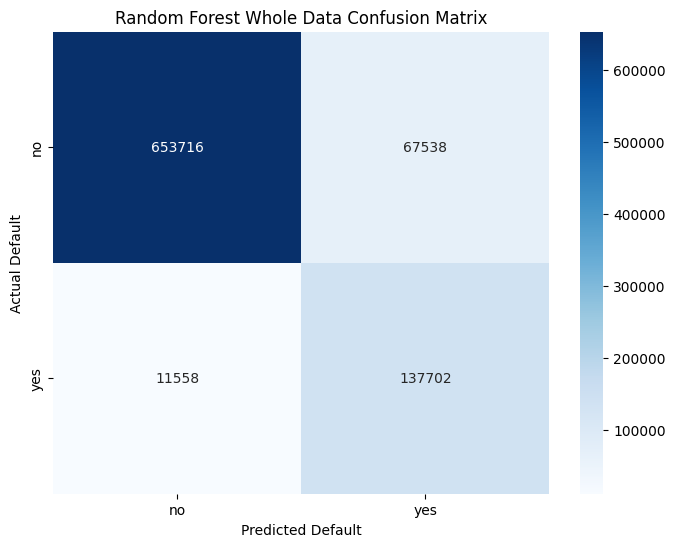

In [33]:
scoring_utils.get_confusion_matrix(y_total, yhat_total, "Random Forest Whole Data")

### Boosting

In [91]:
import xgboost as xgb

In [93]:
xgbmodel = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 verbosity=2,
 max_depth=11,
 min_child_weight=10,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=5,
 seed=27)

xgb_param = xgbmodel.get_xgb_params()
xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgbmodel.get_params()['n_estimators'], nfold=5,
metrics='auc', early_stopping_rounds=50)
xgbmodel.set_params(n_estimators=cvresult.shape[0])

xgbmodel.fit(X_train, y_train, eval_metric='auc')



/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [94]:
yhat_train = xgbmodel.predict(X_train)
yhat_test = xgbmodel.predict(X_test)

cv_boost_score = pd.concat((
    scoring_utils.get_metrics(y_train, yhat_train, 'CV Boosting Train'),
    scoring_utils.get_metrics(y_test, yhat_test, 'CV Boosting Test')
))

cv_boost_score

,Recall,Precision,ROC,F1
CV Boosting Train,0.946244,0.730260,0.936970,0.824340
CV Boosting Test,0.924768,0.720135,0.925074,0.809723


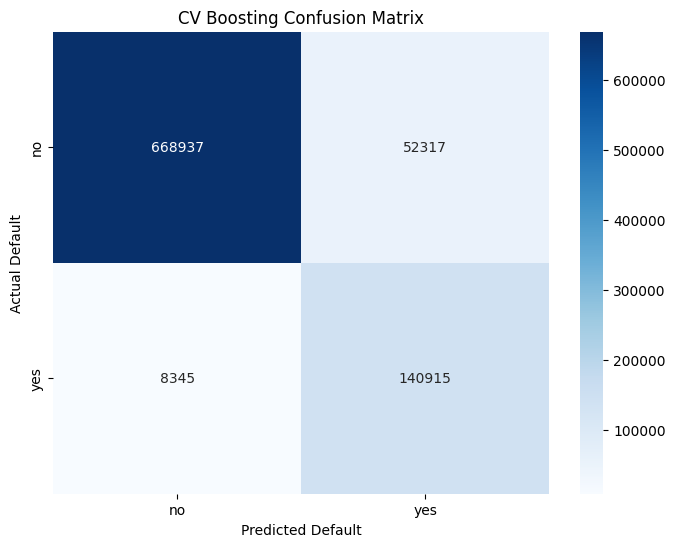

In [95]:
yhat_total = xgbmodel.predict(X_total)
scoring_utils.get_confusion_matrix(y_total, yhat_total, 'CV Boosting')

In [96]:
print(f"We obtained a profit of ${scoring_utils.get_profit(X_total, y_total, yhat_total):,.2f}")

We obtained a profit of $6,741,650,314.00


In [81]:
print(f"The maximum is ${scoring_utils.get_profit(X_total, y_total, y_total):,.2f}")

The maximum is $7,576,088,053.80


# This fuckers works worse. Check if there's time

In [97]:
from xgboost import XGBClassifier

param_grid = [{
    'scale_pos_weight': [3, 4, 4.5, 5, 5.5, 6]
}]

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=12)

xgbsearch = HalvingGridSearchCV(
    xgb.XGBClassifier(
        learning_rate =0.1,
        n_estimators=100,
        verbosity=2,
        max_depth=11,
        min_child_weight=10,
        gamma=0.1,
        subsample=0.9,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        seed=27),
    param_grid=param_grid,
    verbose=1,
    cv=cv,
    scoring='recall'
)

xgbsearch.fit(X_train, y_train)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 261154
max_resources_: 783462
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 261154
Fitting 9 folds for each of 6 candidates, totalling 54 fits
----------
iter: 1
n_candidates: 2
n_resources: 783462
Fitting 9 folds for each of 2 candidates, totalling 18 fits


HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=12),
                    estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.1,
                                            grow_policy=None,
                                            im...
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=11,
                                            max_leaves=None,
                                            min_child_weight=10, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...),
                    param_grid=[{'scale_pos_weight': [3, 4, 4.5, 5, 5.5, 6]}],
                    scoring='recall', verbose=1)

In [98]:
scoring_utils.get_best_kernels(xgbsearch.cv_results_)

,params,mean_test_score,mean_fit_time
kernel,,,
6,{'scale_pos_weight': 6},0.931061,3.705350
5.5,{'scale_pos_weight': 5.5},0.927095,3.805180
6,{'scale_pos_weight': 6},0.918302,1.409347
5.5,{'scale_pos_weight': 5.5},0.915061,1.407623
5,{'scale_pos_weight': 5},0.910407,1.372837
4.5,{'scale_pos_weight': 4.5},0.904992,1.419456
4,{'scale_pos_weight': 4},0.899294,1.363128
3,{'scale_pos_weight': 3},0.882856,1.296614


In [99]:
xgbmodel = xgbsearch.best_estimator_

yhat_test = xgbmodel.predict(X_test)
yhat_total = xgbmodel.predict(X_total)

In [100]:
xgb_test_score = scoring_utils.get_metrics(y_test, yhat_test, "XGB Test")
xgb_total_score = scoring_utils.get_metrics(y_total, yhat_total, "XGB Total")

xgb_score = pd.concat((xgb_test_score, xgb_total_score))
xgb_score

,Recall,Precision,ROC,F1
XGB Test,0.932719,0.700030,0.924867,0.799794
XGB Total,0.951782,0.708222,0.935317,0.812134


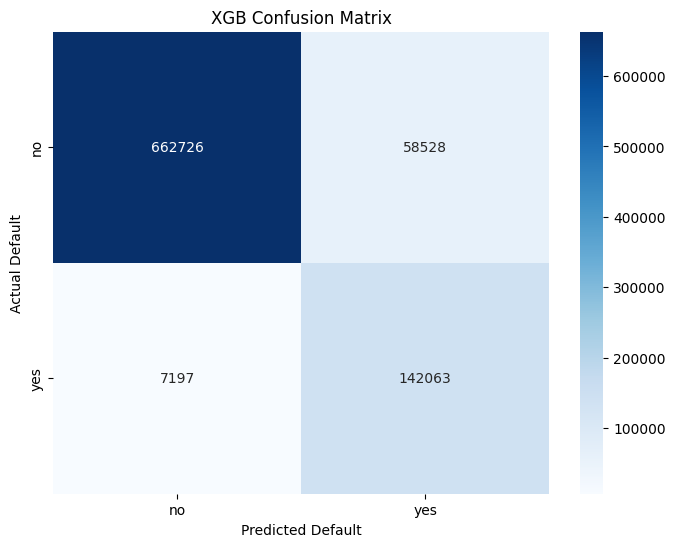

In [101]:
scoring_utils.get_confusion_matrix(y_total, yhat_total, "XGB")

In [102]:
print(f"We obtained a profit of ${scoring_utils.get_profit(X_total, y_total, yhat_total):,.2f}")

We obtained a profit of $6,699,918,822.40


# Hyperopt

In [46]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [47]:

xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 verbosity=2,
 max_depth=11,
 min_child_weight=10,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=5,
 seed=27)
modelfit(xgb1, X_train, y_train)

KeyboardInterrupt: 

In [52]:
from sklearn.metrics import recall_score

In [48]:
space={
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'max_depth': hp.quniform("max_depth", 9, 12, 1),
        'gamma': hp.uniform ('gamma', 0, 1.5),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 20, 1),
        'scale_pos_weight': 5,
        'subsample': .9
    }

In [49]:
from xgboost import XGBClassifier

In [ ]:

xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 verbosity=2,
 max_depth=11,
 min_child_weight=10,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=5,
 seed=27)
modelfit(xgb1, X_train, y_train)

In [ ]:
model = XGBClassifier(
        learning_rate= 0.1, 
        max_depth = 11,
        gamma = 0.1,           
        colsample_bytree= .8,
        min_child_weight= 10,
        scale_pos_weight= 5,
        subsample= .9,
        n_estimators = 100, 
        eval_metric='recall',
        early_stopping_rounds=10 ,
        verbosity=2,
        objective= 'binary:logistic'
    )

In [62]:
from sklearn.metrics import f1_score

In [69]:
def hyperparameter_tuning(space):
    model = XGBClassifier(
        learning_rate= space['learning_rate'], 
        max_depth = int(space['max_depth']),
        gamma = space['gamma'],           
        reg_alpha = int(space['reg_alpha']),
        reg_lambda = space['reg_lambda'],
        colsample_bytree=space['colsample_bytree'],
        min_child_weight=space['min_child_weight'],
        scale_pos_weight= 5,
        subsample= .9,
        n_estimators = 100, 
        eval_metric='auc',
        early_stopping_rounds=10 
    )

    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train,
            eval_set=evaluation,
            verbose=True)

    pred = model.predict(X_test)
    recall = f1_score(y_test, pred)
    print ("SCORE:", recall)
    #change the metric if you like
    return {'loss': -recall, 'status': STATUS_OK, 'model': model}

In [80]:
scoring_utils.get_profit(X_total, y_total, y_total)

7576088053.799957

In [ ]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print (best)

In [71]:
trial = XGBClassifier(
    objective='binary:logistic',
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    learning_rate=best['learning_rate'],
    max_depth=int(best['max_depth']),
    min_child_weight=best['min_child_weight'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    scale_pos_weight= 5,
    subsample= .9,
    n_estimators = 100, 
    eval_metric='auc'
)

old_version = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 verbosity=2,
 max_depth=11,
 min_child_weight=10,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=5,
 seed=27)

In [ ]:

evaluation = [( X_train, y_train), ( X_test, y_test)]
    
trial.fit(X_train, y_train,
            eval_set=evaluation,
            verbose=True)

In [73]:
yhat_test = trial.predict(X_test)
yhat_total = trial.predict(X_total)


In [74]:
scoring_utils.get_metrics(y_test, yhat_test, "Trial Test")

,Recall,Precision,ROC,F1
Trial Test,0.925904,0.639472,0.908759,0.756482


In [75]:
scoring_utils.get_metrics(y_total, yhat_total, "Trial Test")

,Recall,Precision,ROC,F1
Trial Test,0.929472,0.636288,0.909761,0.755431


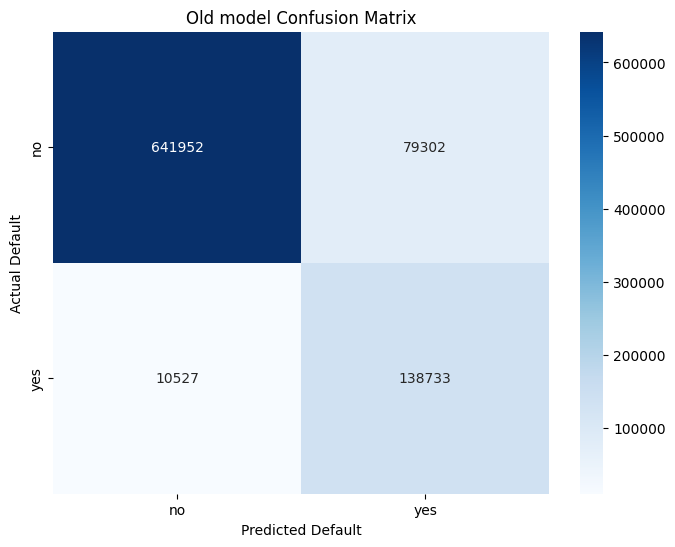

In [76]:
scoring_utils.get_confusion_matrix(y_total, yhat_total, "Old model")

In [79]:
scoring_utils.get_profit(X_total, y_total, yhat_total)

6436802782.949975